<a href="https://colab.research.google.com/github/Ssurf777/physics_informed_neural_network/blob/main/DeepXDE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 59.1 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import random
import faiss
import time
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN

# ランダムシードの設定
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# 形状ファイル

In [ ]:
def read_off(file):
    if 'OFF' != file.readline().strip():
        raise ValueError('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

# 内挿域サンプリング

In [ ]:
# 内挿域サンプリング
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * (side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t - s) * pt2[i] + (1 - t) * pt3[i]
        return (f(0), f(1), f(2))

    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = self.triangle_area(verts[faces[i][0]],
                                          verts[faces[i][1]],
                                          verts[faces[i][2]])

        sampled_faces = random.choices(faces, weights=areas, k=self.output_size)
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = self.sample_point(verts[sampled_faces[i][0]],
                                                  verts[sampled_faces[i][1]],
                                                  verts[sampled_faces[i][2]])
        return sampled_points


# 球体形状作成

In [ ]:
# 球の点群生成
def create_points(num_points=500, radius=1.0):
    theta = torch.rand(num_points) * 2 * torch.pi  # 0から2πの範囲でランダムに生成
    phi = torch.acos(2 * torch.rand(num_points) - 1)  # 0からπの範囲でランダムに生成

    x = radius * torch.sin(phi) * torch.cos(theta)
    y = radius * torch.sin(phi) * torch.sin(theta)
    z = radius * torch.cos(phi)

    return torch.stack([x, y, z], dim=1)


# Chair ModelNet10のインポート

In [ ]:
# 点群生成とクラスター化
def create_chair_points(num_points=500, radius=1.0):
    file_names = [f"/content/drive/MyDrive/chair/chair_{i:04d}.off" for i in range(1,2)]
    for file_name in file_names:
        with open(file_name, 'r') as f:
            verts, faces = read_off(f)
            i,j,k = np.array(faces).T
            x,y,z = np.array(verts).T

            pointcloud = PointSampler(num_points)((verts,faces))

            # traindata
            train_x = pointcloud[:,0]
            train_y = pointcloud[:,1]
            train_z = pointcloud[:,2]
            # Convert NumPy arrays to PyTorch tensors before normalization
            train_x = torch.tensor(train_x)
            train_y = torch.tensor(train_y)
            train_z = torch.tensor(train_z)
            train_xn = (train_x - train_x.min() )/ (train_x.max() - train_x.min())
            train_yn = (train_y - train_y.min() )/ (train_y.max() - train_y.min())
            train_zn = (train_z - train_z.min() )/ (train_z.max() - train_z.min())
            return torch.stack([train_xn, train_yn, train_zn], dim=1)


# クラスタリング

In [ ]:
# クラスタリング
def create_clusters(points, k=4):
    distances = torch.cdist(points, points)
    clusters = []
    for i in range(len(points)):
        closest_neighbors_idx = torch.topk(distances[i], k + 1, largest=False)[1][1:]
        clusters.append(points[closest_neighbors_idx])
    return clusters

# k-means クラスタリング
def create_clusters_with_kmeans(points, k=4, n_clusters=10):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42).fit(points.cpu().numpy())
    labels = kmeans.labels_
    clusters = []

    for label in range(n_clusters):
        cluster_points = points[torch.tensor(labels) == label]
        if len(cluster_points) > k:
            clusters.extend(create_clusters(cluster_points, k=k))
        else:
            clusters.append(cluster_points)

    return clusters

# DBSCAN クラスタリング
def create_clusters_with_DBSCAN(points, eps=0.5, min_samples=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    points_np = points.to(device).float().detach().cpu().numpy()

    # Perform DBSCAN clustering
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(points_np)

    # Create clusters based on labels
    labels = db.labels_
    clusters = [points[torch.tensor(labels == i, device=device)] for i in range(max(labels) + 1)]

    return clusters


# 偏微分方程式の計算定義

In [ ]:
# ラプラシアンの計算
def compute_laplacian_with_clusters(model, clusters):
    laplacians = []
    for cluster in clusters:
        cluster.requires_grad_(True)
        T = model(cluster)

        grad_T = torch.autograd.grad(outputs=T, inputs=cluster,
                                     grad_outputs=torch.ones_like(T),
                                     create_graph=True)[0]

        laplacian = 0
        for i in range(cluster.shape[1]):
            grad2_T = torch.autograd.grad(grad_T[:, i], cluster,
                                          grad_outputs=torch.ones_like(grad_T[:, i]),
                                          create_graph=True, retain_graph=True)[0][:, i]
            laplacian += grad2_T

        laplacians.append(laplacian.mean())
    return torch.stack(laplacians)

def compute_laplacian_with_clusters_batch(model, clusters, batch_size=32):
    laplacians = []
    for i in range(0, len(clusters), batch_size):
        batch = clusters[i:i+batch_size]
        batch = torch.stack(batch).to(next(model.parameters()).device)
        batch.requires_grad_(True)

        T = model(batch)

        grad_T = torch.autograd.grad(outputs=T, inputs=batch,
                                     grad_outputs=torch.ones_like(T),
                                     create_graph=True, allow_unused=True)[0]

        if grad_T is None:
            #print("grad_T is None, skipping this batch.")
            continue

        laplacians_batch = []
        for j in range(batch.shape[0]):
            laplacian = torch.tensor(0.0, device=batch.device)  # Tensorとして初期化
            for i in range(batch.shape[2]):
                grad2_T = torch.autograd.grad(grad_T[j][:, i], batch[j],
                                              grad_outputs=torch.ones_like(grad_T[j][:, i]),
                                              create_graph=True, retain_graph=True,
                                              allow_unused=True)[0]
                if grad2_T is None:
                    #print(f"grad2_T is None for batch {j}, skipping this gradient.")
                    continue

                laplacian += grad2_T
            laplacians_batch.append(laplacian.mean())

        laplacians.extend(laplacians_batch)

    return torch.stack(laplacians)
# ======================================================================================================
# クラスタリングなしのラプラシアンの計算
def compute_laplacian_without_clustering(model, points):
    points.requires_grad_(True)
    T = model(points)

    # 勾配 (一次微分) の計算
    grad_T = torch.autograd.grad(outputs=T, inputs=points,
                                 grad_outputs=torch.ones_like(T),
                                 create_graph=True)[0]

    # 二次微分（ラプラシアン）の計算
    laplacian = torch.zeros(points.shape[0], device=points.device)
    for i in range(points.shape[1]):  # 各次元 (x, y, z) に対して
        grad2_T = torch.autograd.grad(grad_T[:, i], points,
                                      grad_outputs=torch.ones_like(grad_T[:, i]),
                                      create_graph=True, retain_graph=True)[0][:, i]
        laplacian += grad2_T

    return laplacian.mean()  # 平均を取る


# DeepXDE

In [ ]:
!pip install deepxde

In [ ]:
import deepxde as dde
import torch
from deepxde import gradients as dde_grad

# バックエンドをPyTorchに設定
dde.backend.set_default_backend("pytorch")  # 修正

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ラプラシアンの計算
def dde_compute_laplacian_without_clustering(model, points):
    """
    DeepXDEでラプラシアンを計算する関数。
    """
    # 入力ポイントをTensorに変換
    points_torch = torch.tensor(points, dtype=torch.float32).clone().detach().requires_grad_(True).to(device)

    # モデル出力
    T = model(points_torch)

    # 勾配 (一次微分) の計算
    grad_T = []
    for i in range(points_torch.shape[1]):  # 各次元 (x, y, z) に対して
        grad = torch.autograd.grad(
            T, points_torch, grad_outputs=torch.ones_like(T), create_graph=True, retain_graph=True
        )[0][:, i]
        grad_T.append(grad)
    grad_T = torch.stack(grad_T, dim=-1)

    # ラプラシアン（二次微分の和）の計算
    laplacian = torch.zeros(points_torch.shape[0]).to(device)
    for i in range(points_torch.shape[1]):  # 各次元 (x, y, z) に対して
        grad2_T = torch.autograd.grad(
            grad_T[:, i], points_torch, grad_outputs=torch.ones_like(grad_T[:, i]), create_graph=True, retain_graph=True
        )[0][:, i]
        laplacian += grad2_T

    return laplacian  # ラプラシアンを返す


Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


# Neural Network Difine

In [ ]:
# モデル定義
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x.float()))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# AutogradPINNの学習定義

In [ ]:
# PINNの学習
def autograd_train_pinn_with_clusters(model, points, heat_source, epochs=100, k=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    points = points.to(device)
    heat_source = heat_source.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    #clusters = create_clusters_with_kmeans(points, k=k) # k-meansクラスタリング
    clusters = create_clusters_with_DBSCAN(points, eps=0.5, min_samples=4) # DBSCANクラスタリング
    start_time = time.time()  # 学習全体の開始時間

    for epoch in range(epochs):
        epoch_start_time = time.time()  # エポックの開始時間
        model.train()
        total_loss = 0

        for i, point in enumerate(points):
            #distance_to_source = torch.norm(point - heat_source)
            distance_to_source = torch.sum(torch.abs(point - heat_source))  # 熱源までのL1ノルムを計算

            expected_temperature = 1 / (distance_to_source + 1e-8)

            laplacian = compute_laplacian_with_clusters(model, clusters)
            #laplacian = compute_laplacian_with_clusters_batch(model, [clusters[i]], batch_size=32)
            loss_laplacian = torch.mean(laplacian[0] ** 2)
            loss_temperature = torch.mean((model(point.unsqueeze(0)) - expected_temperature) ** 2)

            loss = loss_laplacian + loss_temperature
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

        # エポックの経過時間を計算
        epoch_time = time.time() - epoch_start_time
        # 全体の経過時間
        elapsed_time = time.time() - start_time
        # 残りのエポック数
        remaining_epochs = epochs - (epoch + 1)
        # 残り時間の推定
        estimated_remaining_time = (elapsed_time / (epoch + 1)) * remaining_epochs

        if epoch % 10 == 0:
            print(f"Epoch: {epoch + 1}/{epochs} | Elapsed Time: {elapsed_time:.2f}s | Estimated Remaining Time: {estimated_remaining_time:.2f}s")
            print(f'Epoch {epoch + 1}, Loss: {total_loss / len(points)}')


In [ ]:
# PINNの学習 (クラスタリングなし)
def autograd_train_pinn_without_clusters(model, points, heat_source, epochs=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    points = points.to(device)
    heat_source = heat_source.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    start_time = time.time()  # 学習全体の開始時間

    for epoch in range(epochs):
        epoch_start_time = time.time()  # エポックの開始時間
        model.train()
        total_loss = 0

        for i, point in enumerate(points):
            #distance_to_source = torch.norm(point - heat_source)
            distance_to_source = torch.sum(torch.abs(point - heat_source))  # 熱源までのL1ノルムを計算

            expected_temperature = 1 / (distance_to_source + 1e-8)

            # クラスタリングなしでラプラシアンを計算
            laplacian = compute_laplacian_without_clustering(model, points)
            loss_laplacian = torch.mean(laplacian ** 2)
            loss_temperature = torch.mean((model(point.unsqueeze(0)) - expected_temperature) ** 2)

            loss = loss_laplacian + loss_temperature
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

        # エポックの経過時間を計算
        epoch_time = time.time() - epoch_start_time
        # 全体の経過時間
        elapsed_time = time.time() - start_time
        # 残りのエポック数
        remaining_epochs = epochs - (epoch + 1)
        # 残り時間の推定
        estimated_remaining_time = (elapsed_time / (epoch + 1)) * remaining_epochs

        if epoch % 10 == 0:
            print(f"Epoch: {epoch + 1}/{epochs} | Elapsed Time: {elapsed_time:.2f}s | Estimated Remaining Time: {estimated_remaining_time:.2f}s")
            print(f'Epoch {epoch + 1}, Loss: {total_loss / len(points)}')


# DeepXDE　学習

In [ ]:
import torch
import time
from torch import optim
# PINNの学習 (DeepXDE + クラスタリングなし)
def dde_train_pinn_without_clusters(model, points, heat_source, epochs=100):
    """
    DeepXDE用のPINN学習関数。
    """
    # デバイス設定
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    points = points.clone().detach().requires_grad_(True).to(device)
    heat_source = heat_source.clone().detach().to(device)

    model.to(device)

    # Optimizer設定
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 学習開始時間
    start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()  # エポック開始時間
        model.train()  # モデルを訓練モードに設定
        total_loss = 0

        for i, point in enumerate(points):
            point = point.unsqueeze(0)  # 次元を追加
            #distance_to_source = torch.norm(point - heat_source)  # 熱源までの距離を計算
            distance_to_source = torch.sum(torch.abs(point - heat_source))  # 熱源までのL1ノルムを計算
            expected_temperature = 1 / (distance_to_source + 1e-8)  # 期待温度を計算

            # ラプラシアンをDeepXDE経由で計算
            laplacian = dde_compute_laplacian_without_clustering(model, points)
            loss_laplacian = torch.mean(laplacian ** 2)  # ラプラシアンに基づく損失
            loss_temperature = torch.mean((model(point) - expected_temperature) ** 2)  # 温度に基づく損失

            # 合計損失を計算
            loss = loss_laplacian + loss_temperature
            total_loss += loss.item()

            # 勾配更新
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

        # エポックの経過時間と推定残り時間を計算
        epoch_time = time.time() - epoch_start_time
        elapsed_time = time.time() - start_time
        remaining_epochs = epochs - (epoch + 1)
        estimated_remaining_time = (elapsed_time / (epoch + 1)) * remaining_epochs

        # 進捗ログを出力
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch: {epoch + 1}/{epochs} | Elapsed Time: {elapsed_time:.2f}s | Estimated Remaining Time: {estimated_remaining_time:.2f}s")
            print(f"Epoch {epoch + 1}, Loss: {total_loss / len(points)}")


In [ ]:
# 推論と可視化
def infer_and_visualize(model, points):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    points = points.to(device)

    with torch.no_grad():
        temperatures = model(points).cpu().numpy()

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = points[:, 0].detach().cpu().numpy()
    y = points[:, 1].detach().cpu().numpy()
    z = points[:, 2].detach().cpu().numpy()

    grid_x, grid_y, grid_z = np.mgrid[0:1:100j, 0:1:100j, 0:1:100j]
    grid_temp = griddata(np.vstack((x, y, z)).T, temperatures.flatten(), (grid_x, grid_y, grid_z), method='linear')

    scatter = ax.scatter(x, y, z, c=temperatures.flatten(), cmap='inferno', vmin=0, vmax=1)
    fig.colorbar(scatter, ax=ax, label='Temperature')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()


# 【結果】Deep-XDE

<ipython-input-26-ee5598062233>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points_torch = torch.tensor(points, dtype=torch.float32).clone().detach().requires_grad_(True).to(device)


Epoch: 1/100 | Elapsed Time: 14.48s | Estimated Remaining Time: 1433.78s
Epoch 1, Loss: 0.44500308766282715
Epoch: 11/100 | Elapsed Time: 90.78s | Estimated Remaining Time: 734.48s
Epoch 11, Loss: 0.07041723594358913
Epoch: 21/100 | Elapsed Time: 166.42s | Estimated Remaining Time: 626.05s
Epoch 21, Loss: 0.05297721662086864
Epoch: 31/100 | Elapsed Time: 239.49s | Estimated Remaining Time: 533.06s
Epoch 31, Loss: 0.04660402477606736
Epoch: 41/100 | Elapsed Time: 314.26s | Estimated Remaining Time: 452.23s
Epoch 41, Loss: 0.03629520261547402
Epoch: 51/100 | Elapsed Time: 388.21s | Estimated Remaining Time: 372.98s
Epoch 51, Loss: 0.03214054461799797
Epoch: 61/100 | Elapsed Time: 462.46s | Estimated Remaining Time: 295.67s
Epoch 61, Loss: 0.033896406819206054
Epoch: 71/100 | Elapsed Time: 535.89s | Estimated Remaining Time: 218.88s
Epoch 71, Loss: 0.02929119205611611
Epoch: 81/100 | Elapsed Time: 609.99s | Estimated Remaining Time: 143.08s
Epoch 81, Loss: 0.031688023485692024
Epoch: 91/1

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

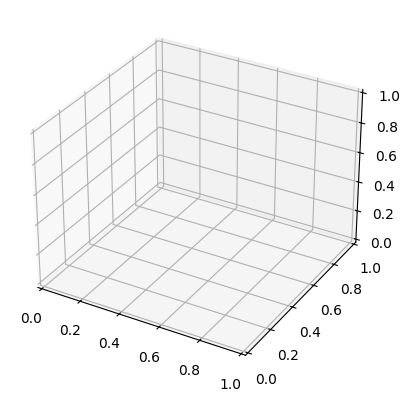

In [ ]:

# 使用例
points = create_chair_points()
model = PINN()
# DeepXDE用の学習コード
dde_train_pinn_without_clusters(model, points, torch.tensor([1, 1, 1]))  # 任意の熱源を設定
infer_and_visualize(model, points)

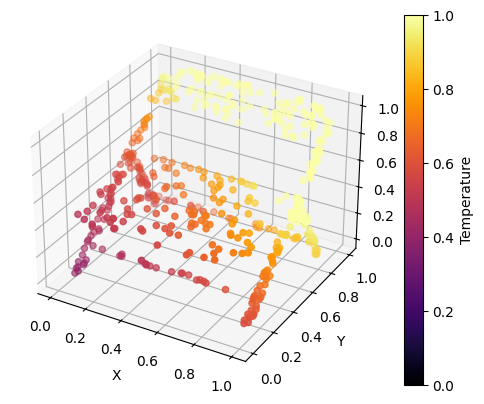

In [ ]:
infer_and_visualize(model, points)

# 【結果】クラスタリング+Autograd

Epoch: 1/100 | Elapsed Time: 3.76s | Estimated Remaining Time: 371.93s
Epoch 1, Loss: 0.494971182379985
Epoch: 11/100 | Elapsed Time: 39.65s | Estimated Remaining Time: 320.77s
Epoch 11, Loss: 0.16634701430962223
Epoch: 21/100 | Elapsed Time: 77.57s | Estimated Remaining Time: 291.80s
Epoch 21, Loss: 0.12520127460807376
Epoch: 31/100 | Elapsed Time: 113.82s | Estimated Remaining Time: 253.34s
Epoch 31, Loss: 0.09282883590390997
Epoch: 41/100 | Elapsed Time: 149.88s | Estimated Remaining Time: 215.68s
Epoch 41, Loss: 0.13834132053107756
Epoch: 51/100 | Elapsed Time: 185.70s | Estimated Remaining Time: 178.42s
Epoch 51, Loss: 0.08334289970977067
Epoch: 61/100 | Elapsed Time: 221.20s | Estimated Remaining Time: 141.42s
Epoch 61, Loss: 0.03766159742779358
Epoch: 71/100 | Elapsed Time: 257.35s | Estimated Remaining Time: 105.12s
Epoch 71, Loss: 0.03328902227412106
Epoch: 81/100 | Elapsed Time: 292.80s | Estimated Remaining Time: 68.68s
Epoch 81, Loss: 0.039297327557294266
Epoch: 91/100 | El

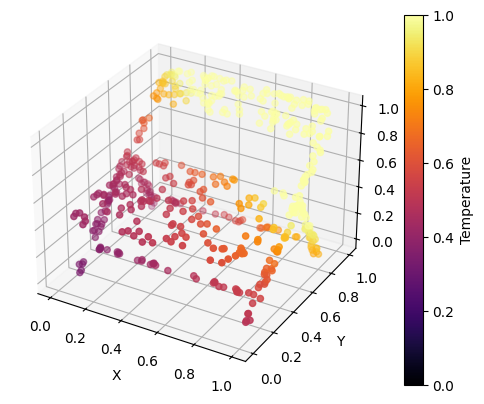

In [ ]:
# クラスタリング使用+Autograd
points = create_chair_points()
model2 = PINN()
autograd_train_pinn_with_clusters(model2, points, torch.tensor([1, 1, 1]))  # 任意の熱源を設定
#autograd_train_pinn_without_clusters(model2, points, torch.tensor([1, 1, 1]))  # 任意の熱源を設定
infer_and_visualize(model2, points)